## Softmax

Обобщение логистической функции для многомерного случая. Функция преобразует вектор $z$ размерности $K$ в вектор $\sigma$ той же размерности, где каждая координата $\sigma_i$ полученного вектора представлена вещественным числом в интервале $[0,1]$ и сумма координат равна 1.

Координаты $\sigma_i$ вычисляются следующим образом:


${\displaystyle \sigma (z)_{i}={\frac {e^{z_{i}}}{\displaystyle \sum _{k\mathop {=} 1}^{K}e^{z_{k}}}}}$

1. Реализуйте функцию softmax, которая на вход принимает вектор $z$, а на выходе считает от него софтмакс.
2. Добавьте возможность принимать на вход матрицу и считать softmax по столбцам (батч)

In [1]:
import numpy as np

In [4]:
def softmax(z):
    res = np.exp(z)
    return res/sum(res)

In [5]:
def batch_softmax(z):
    return np.apply_along_axis(softmax, 0, z)
    

## Дивергенция Кульбака-Лейблера

* Показать что $D_{KL}(p||q) \ge 0$ для любых $p$ и $q$. Для этого можно воспользоваться [формулой Йенсена](https://en.wikipedia.org/wiki/Jensen%27s_inequality "неравенство Йенсена")
* ~~Показать, что максимизация правдопобия эквивалентна минимизации $D_{KL}$~~. 

$$D_{KL}(p||q)=\sum_{x}p(x)(log(p(x))-log(q(x))=\sum_{x}p(x)(-log(\frac{q(x)}{p(x)})$$
Неравенство Йенсена:
$$f(\sum_{i}\alpha_ix_i)\le \sum_{i}\alpha_if(x_i), при \sum_i\alpha_i =1$$
То, что написано в правой части неравенства Йенсена, похоже на правую часть расстояния Кульбака — Лейблера. Совпадение? Не думаю.
$$D_{KL}(p||q) \ge -log(\sum_{x}p_{x}\frac{q(x)}{p(x)})=-log(\sum_xq(x))=-log(1)=0$$ 


## Обучение линейных моделей

Буквально три-четыре года назад для того, чтобы обучить нейронную сеть было необходимо вручную вычислить градиент функции потерь. Затем, обычно, правильность решения проверялась численно. После появления фреймворков вроде Theano и TF это стало необязательным, благодаря чему исследователи и инженеры могут проводить свои эксперименты значительно быстрее. В данной работе мы посчитаем и проверим градиенты для линейных моделей, рассмотренных на первой лекции; а так же в явном виде реализуем алгоритм оптимизации.      

In [6]:
import numpy as np
from keras.datasets import cifar10
from random import randrange
import time

Using TensorFlow backend.
/home/artyom/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [9]:
x_train.shape

(50000, 32, 32, 3)

Визуализируем классы

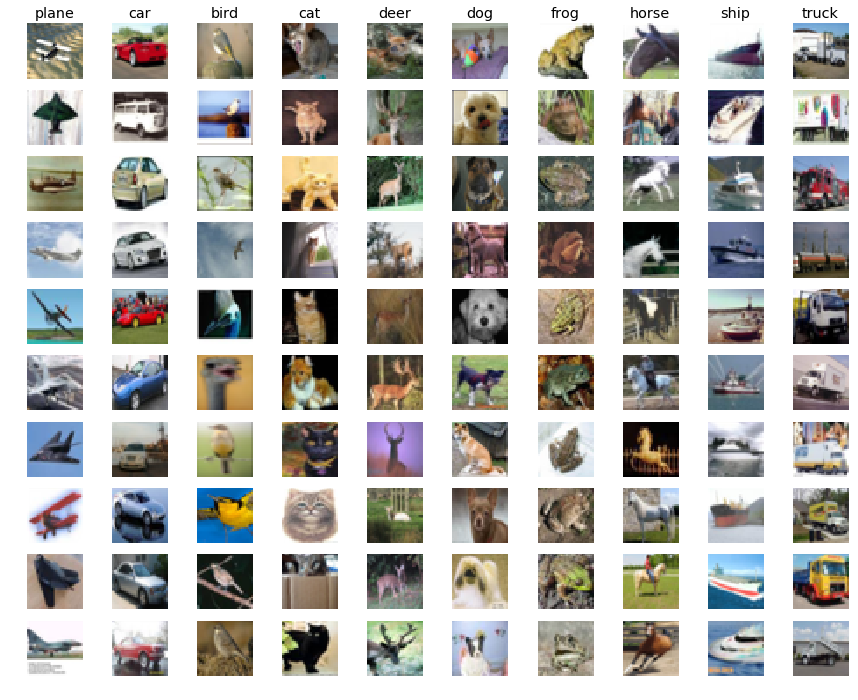

In [10]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [11]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[ 130.71074  136.05614  132.5538   130.14036  135.44238  131.85358
  131.05044  136.24616  132.58144  131.56886]


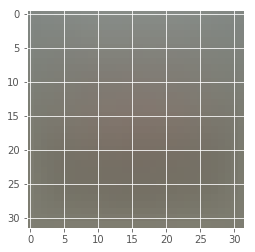

In [12]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [13]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [14]:
print(x_train.shape)

(50000, 3072)


In [15]:
# 3: Добавляем новую компоненту отвечающую за сдвиг (bias trick)
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

In [16]:
print(x_train.shape)

(50000, 3073)


**Задача 1:** Далее следует функция svm_loss, которую вам предстоит дописать.

**Потеря на одном элементе:**
$$L_i=\sum_{j\neq y_i}max(0,<w_j,x_i>)$$
**$L_2$-регуляризация:** 
$$R(W)=\sum_i\sum_jw_{i,j}^2$$
**Функция потерь:**
$$L=\frac{1}{N}\sum_iL_i + \lambda R(W)$$
**Частная производная** $\frac{\delta L_i}{\delta w_{i,j}}$:
$$\frac{\delta L_k}{\delta w_{i,j}}=x_{k,j}I(max(0,<w_i,x_k>) > 0)I(i \neq y_k)$$
**Частная производная** $\frac{\delta L}{\delta w_{i,j}}$:
$$\frac{\delta L}{\delta w_{i,j}}=\sum_kx_{k,j}I(max(0,<w_i,x_k>) > 0)I(i \neq y_k) +2\lambda w_{i,j}$$

In [39]:
def svm_loss(W, X, y, reg):
    """
    SVM loss function
    Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    # Впишите свой код на место заглушки
    loss = 0
    
    dW = np.zeros(W.shape)
    
    #sub_dw = lambda W, los, reg: np.ones(W.shape)
    
    for i,w in enumerate(W):
        
        class_i_losses = (X*w).sum(axis=1)
        
        loss += class_i_losses[(class_i_losses>0)*(y!=i).ravel()].sum()/len(X)
        
        dW[i] = X[(class_i_losses>0)*(y!=i).ravel()].sum(axis=0)/len(X)
    
        
    dW += 2*reg*W

    return loss, dW

In [42]:
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001 

loss, grad = svm_loss(W, x_test, y_test, 0.000005)
print('loss: %f' % (loss, ))

loss: 1.097799


In [43]:
#При помощи этой функции можно проверить градиент численно 
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """
    h = 1e-5

    x.shape
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        x[ix] += h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] -= 2 * h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] += h # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [44]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = svm_loss(W, x_test, y_test, 0.0)

# Проверяем численно
f = lambda w: svm_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Проверяем численно, используя регуляризацию.
# Вы ведь не забыли реализовать регуляризацию, правда? 
loss, grad = svm_loss(W, x_test, y_test, 5e1)
f = lambda w: svm_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.389376 analytic: -0.384205, relative error: 6.684253e-03
numerical: 8.998377 analytic: 8.998749, relative error: 2.065968e-05
numerical: -0.690155 analytic: -0.688369, relative error: 1.295718e-03
numerical: -6.741618 analytic: -6.747442, relative error: 4.317523e-04
numerical: 2.135187 analytic: 2.118465, relative error: 3.931242e-03
numerical: -1.904054 analytic: -1.904954, relative error: 2.362312e-04
numerical: -2.080134 analytic: -2.089684, relative error: 2.290339e-03
numerical: 3.876273 analytic: 3.879107, relative error: 3.654267e-04
numerical: -4.339879 analytic: -4.345064, relative error: 5.970024e-04
numerical: -6.290516 analytic: -6.289419, relative error: 8.722856e-05
numerical: -19.480211 analytic: -19.477824, relative error: 6.126229e-05
numerical: 4.844030 analytic: 4.827391, relative error: 1.720434e-03
numerical: 1.570378 analytic: 1.568706, relative error: 5.324143e-04
numerical: 1.330144 analytic: 1.327359, relative error: 1.047649e-03
numerical: 4.700

**Задача 2:** Реализуйте методы класса SVM. Для тренировки используйте градиентный спуск.

In [104]:
class SVM():
    def __init__(self):
        self.W = np.random.randn(10, 3073) * 0.0001 
        
    def train(self, x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=500, verbose=True):
        
        loss = 0
        loss_history = []
        for it in range(num_iters):
            if(it%100==0):
                print(it)
            loss, dW = svm_loss(self.W, x_train, y_train, reg)
            loss_history.append(loss)
            
            if it > 2 and verbose: 
                if (loss_history[-1] > loss_history[-2]):
                    break
            
            
            self.W -= learning_rate*dW

        return loss_history
    def predict(self, X):
        print(self.W.shape,X[0].shape)
        set_class = lambda x: np.argmax((self.W*x).sum(axis=1),axis=0)
        return np.apply_along_axis(set_class, 1, X)
        

Проверяем полученную реализацию.

In [105]:
tic = time.time()
svm = SVM()
loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=2.5e4,verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

0
100
That took 952.712045s


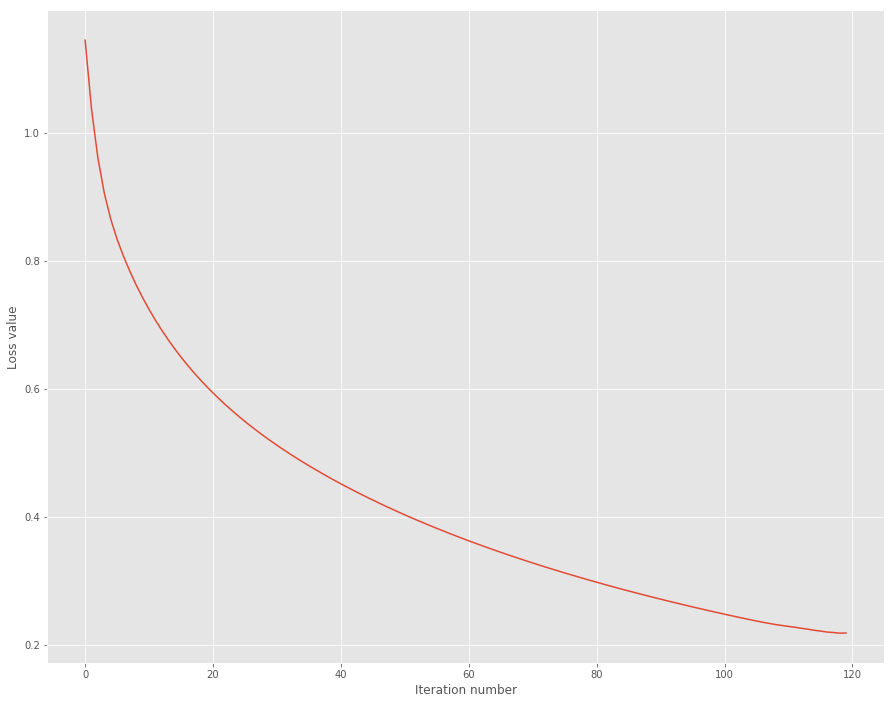

In [106]:
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации 
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [107]:
# Теперь вычислим точность на тренировочном и тестовом множествах
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
#y_val_pred = svm.predict(X_val)
#print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

(10, 3073) (3073,)
training accuracy: 0.100000


In [108]:
def plot_weights(best_svm):
    w = best_svm.W[:,:-1] # strip out the bias
    w = w.reshape(10, 32, 32, 3)
    w_min, w_max = np.min(w), np.max(w)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(10):
        plt.subplot(2, 5, i + 1)

        # Rescale the weights to be between 0 and 255
        wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
        plt.imshow(wimg.astype('uint8'))
        plt.axis('off')
        plt.title(classes[i])

**Задача 3:** Подберите при помощи поиска по сетке наулучшие параметры learning rate и regularization coefficient. Для полученной модели вызовите функцию plot_weights(best_svm). Впишите свой код под этой ячейкой.

In [109]:
learning_rates = np.array([1e-3,1e-4,1e-5,1e-6,1e-7])
regularization_coefficient = np.array([2.5e4,2.5e3,2.5e2,2.5e1])

In [110]:
best_loss = 10000
best_model_par = {}

In [112]:
for l_r in learning_rates:
    for r_c in regularization_coefficient:
        tmp_svm = SVM()
        loss_hist = tmp_svm.train(x_train, y_train, learning_rate=l_r, reg=r_c,verbose=True, num_iters=100)
        if min(loss_hist) < best_loss:
            best_loss = min(loss_hist)
            best_model_par['model'] = tmp_swm
            best_model_par['learning_rates'] = l_r
            best_model_par['regularization_coefficient'] = r_c

0
0
0
0


NameError: name 'tmp_swm' is not defined

In [ ]:
plot_weights(best_model_par['model'])

**Задача 4:** О чём говорят полученные изображения? Какие выводы мы можем сделать? Впишите ответ в поле ниже

**Задача 5:** Повторим упражнение для cross entropy loss

In [ ]:
def crossentropy_loss(W, X, y, reg):
    """
    Cross entropy loss function
   Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    # Впишите свой код на место заглушки
    loss = 0
    dW = np.zeros(W.shape)

    return loss, dW

In [ ]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)

In [ ]:
# Грубая проверка, значения должны быть близки к -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

**Задача 6:** Кстати, почему такая проверка справедлива? Объясните

In [ ]:
f = lambda w: crossentropy_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = crossentropy_loss(W, x_test, y_test, 5e1)
f = lambda w: crossentropy_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)